# Vi-T for CIFAR-10

## Import Libraries

In [1]:
%pip install transformers wandb einops
%pip install "git+https://github.com/b-re-w/lattent.git#egg=lattent[pytorch]"

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Note: you may need to restart the kernel to use updated packages.
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
  Cloning https://github.com/b-re-w/lattent.git to /tmp/pip-install-ckdrsaab/lattent_33470b0dae274befb2e41855209e86af
  Running command git clone --filter=blob:none --quiet https://github.com/b-re-w/lattent.git /tmp/pip-install-ckdrsaab/lattent_33470b0dae274befb2e41855209e86af
  Resolved https://github.com/b-re-w/lattent.git to commit 9f356fcd409ec3475142051bbcbec8422bba255f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
from os import path, mkdir

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
import wandb

### Huggingface login

In [3]:
# Uncomment out the line below when you need to login to Huggingface
#!huggingface-cli login

### Check GPU Availability

In [4]:
!nvidia-smi

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Sun Apr 27 14:22:57 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:04:00.0 Off |                    0 |
| N/A   37C    P0              33W / 250W |   2494MiB / 16384MiB |      0%      Default |
|                                         |                      |                  

In [5]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 6
ADDITIONAL_GPU = 1

if torch.cuda.is_available():
    if ADDITIONAL_GPU:
        torch.cuda.set_device(DEVICE_NUM)
        device = torch.device("cuda")
    else:
        device = torch.device(f"cuda:{DEVICE_NUM}")
else:
    device = torch.device("cpu")
    DEVICE_NUM = -1

print(f"INFO: Using device - {device}" + (f":{DEVICE_NUM}" if ADDITIONAL_GPU else ""))

INFO: Using device - cuda:7


## Load DataSets

In [6]:
from pretraining.datasets import (
    ImageNet1K, CIFAR100, CIFAR10, DatasetHolder,
    IMAGENET1KConfig, CIFAR100Config, CIFAR10Config
)

In [7]:
DATA_ROOT = path.join(".", "data")

IMAGENETs = DatasetHolder(
    config=IMAGENET1KConfig,
    train=ImageNet1K(
        root=DATA_ROOT, force_download=False, train=True, transform=IMAGENET1KConfig.augmentation
    ),
    valid=ImageNet1K(
        root=DATA_ROOT, force_download=False, valid=True, transform=IMAGENET1KConfig.resizer
    ),
    test=ImageNet1K(
        root=DATA_ROOT, force_download=False, train=False, transform=IMAGENET1KConfig.resizer
    )
)
IMAGENETs.split_train_attack()
print(f"INFO: Dataset loaded successfully - {IMAGENETs}")

CIFAR100s = DatasetHolder(
    config=CIFAR100Config,
    train=CIFAR100(
        root=DATA_ROOT, download=True, train=True, transform=CIFAR100Config.augmentation
    ),
    test=CIFAR100(
        root=DATA_ROOT, download=True, train=False, transform=CIFAR100Config.resizer
    )
)
CIFAR100s.split_train_valid()
CIFAR100s.split_train_attack()
print(f"INFO: Dataset loaded successfully - {CIFAR100s}")

CIFAR10s = DatasetHolder(
    config=CIFAR10Config,
    train=CIFAR10(
        root=DATA_ROOT, download=True, train=True, transform=CIFAR10Config.augmentation
    ),
    test=CIFAR10(
        root=DATA_ROOT, download=True, train=False, transform=CIFAR10Config.resizer
    )
)
CIFAR10s.split_train_valid()
CIFAR10s.split_train_attack()
print(f"INFO: Dataset loaded successfully - {CIFAR10s}")

INFO: Downloading 'ILSVRC/imagenet-1k' dataset from huggingface to data/imagenet-1k/train...
INFO: Dataset files found in the root directory. Skipping download.
INFO: Downloading 'ILSVRC/imagenet-1k' dataset from huggingface to data/imagenet-1k/val...
INFO: Dataset files found in the root directory. Skipping download.
INFO: Downloading 'ILSVRC/imagenet-1k' dataset from huggingface to data/imagenet-1k/test...
INFO: Dataset files found in the root directory. Skipping download.
INFO: Dataset loaded successfully - IMAGENET1KDatasetHolder(train=1153050, test=100000, valid=50000, attack=128117)
INFO: Dataset loaded successfully - CIFAR100DatasetHolder(train=40500, test=10000, valid=5000, attack=4500)
INFO: Dataset loaded successfully - CIFAR10DatasetHolder(train=40500, test=10000, valid=5000, attack=4500)


In [8]:
CHOSEN_DATASET = IMAGENETs

train_dataset = CHOSEN_DATASET.train
valid_dataset = CHOSEN_DATASET.valid
test_dataset = CHOSEN_DATASET.test

print(f"INFO: Dataset Size - {CHOSEN_DATASET}")

INFO: Dataset Size - IMAGENET1KDatasetHolder(train=1153050, test=100000, valid=50000, attack=128117)


## DataLoader

In [9]:
# Set Batch Size
BATCH_SIZE = 128, 64, 64

In [10]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues

from platform import system
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    import multiprocessing
    cpu_cores = multiprocessing.cpu_count()
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0
    print("INFO: Using DataLoader without multi-processing.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE[0], shuffle=True, num_workers=cpu_cores)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE[1], shuffle=False, num_workers=cpu_cores)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE[2], shuffle=False, num_workers=cpu_cores)

INFO: Number of CPU cores - 48


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].


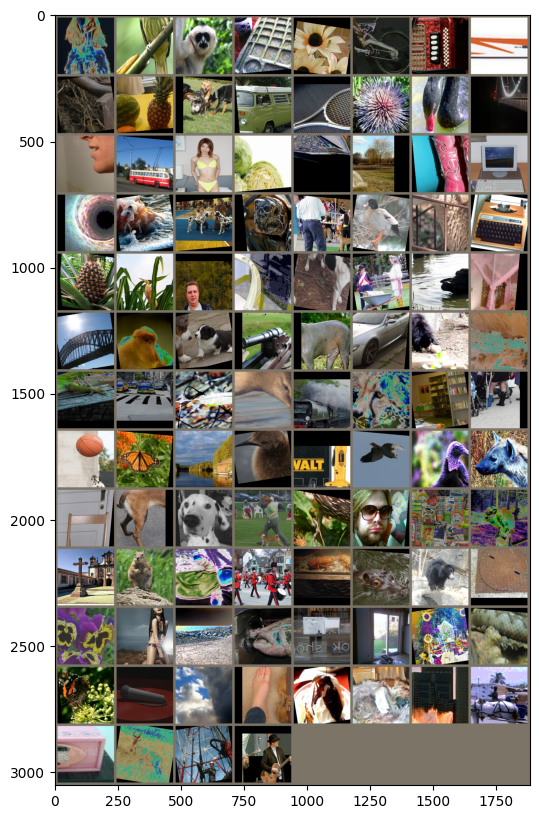

In [11]:
train_loader.show_sample_grid(**CHOSEN_DATASET.config.norm)

## Define Model

In [12]:
from pretraining.models.transformers import (
    ViTBase, ViTLarge,
    SwinTiny, SwinBase, SwinLarge,
    FNetVisionBase, FNetVisionLarge,
    LongformerVisionBase, LongformerVisionLarge,
    TTTVisionTiny, TTTVisionSmall, TTTVisionBase, TTTVisionLarge
)
from pretraining.models.others import (
    ResNet50, ResNet101, ResNet152,
    MLPMixerBase, MLPMixerLarge
)

In [13]:
TargetModel = ViTBase

# WandB Initialization
try:
    wandb.finish()
except:
    pass
project = wandb.init(project="Exp_"+CHOSEN_DATASET.config.name.upper(), name=TargetModel.model_name)

# Initialize Model
TargetModel.dataset_name = CHOSEN_DATASET.config.name
model = TargetModel(image_size=CHOSEN_DATASET.config.size, num_classes=CHOSEN_DATASET.num_classes)

if ADDITIONAL_GPU:
    model = nn.DataParallel(model, device_ids=list(range(DEVICE_NUM, DEVICE_NUM+ADDITIONAL_GPU+1)))
model.to(device)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: brew (brew-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


ViTBase(
  (model): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GE

## Training Loop

In [14]:
def avg(lst):
    try:
        return sum(lst) / len(lst)
    except ZeroDivisionError:
        return 0

In [15]:
# Set Epoch Count & Learning Rate
EPOCHS = 50
LEARNING_RATE = 1e-4, 1e-6
WEIGHT_DECAY = 0.05

criterion = nn.CrossEntropyLoss()
wandb.watch(model, criterion, log="all", log_freq=10)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE[0], weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LEARNING_RATE[1])

In [ ]:
train_length, valid_length = map(len, (train_loader, valid_loader))

epochs = tqdm(range(EPOCHS), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
    tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars

    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        train_acc, train_loss, val_acc, val_loss = [], [], [], []

        # Training
        model.train()
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, targets)  # but not use model loss

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss.append(loss.item())
            train_acc.append((torch.max(outputs, 1)[1] == targets.data).sum().item() / len(inputs))

            train_progress.update(1)
            if i != train_length-1: wandb.log({'Acc': avg(train_acc)*100, 'Loss': avg(train_loss)})
            print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{i+1:2}/{train_length}], Acc: {avg(train_acc):.6%}, Loss: {avg(train_loss):.6f}", end="")

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs, targets)  # but not use model loss

                val_loss.append(criterion(outputs, targets).item())
                val_acc.append((torch.max(outputs, 1)[1] == targets.data).sum().item() / len(inputs))
                valid_progress.update(1)

        wandb.log({'Train Acc': avg(train_acc)*100, 'Train Loss': avg(train_loss), 'Val Acc': avg(val_acc)*100, 'Val Loss': avg(val_loss)})
        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{train_length}/{train_length}], Acc: {avg(train_acc):.6%}, Loss: {avg(train_loss):.6f}, Valid Acc: {avg(val_acc):.6%}, Valid Loss: {avg(val_loss):.6f}", end="\n" if (epoch+1) % 5 == 0 or (epoch+1) == EPOCHS else "")

In [ ]:
# Model Save
if ADDITIONAL_GPU:
    model.model.save()
else:
    model.save()

# Model Evaluation

In [ ]:
# Load Model
model = TargetModel(image_size=CHOSEN_DATASET.config.size, num_classes=len(train_dataset.classes))
model.from_pretrained(version="")
model.to(device)

In [ ]:
corrects = 0
test_length = len(test_dataset)

model.eval()
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs, targets)
        _, preds = torch.max(outputs, 1)
        corrects += (preds == targets.data).sum()
        print(f"Model Accuracy: {corrects/test_length:%}", end="\r")